# Gerando polígonos de vias por setor fiscal município de São Paulo

Esse notebook tem a intenção de ir um pouco além do último Notebook no sentido de avançar para um processamento viável para a publicação de uma nova camada no [Geosampa](http://geosampa.prefeitura.sp.gov.br/PaginasPublicas/_SBC.aspx) 

Para isso vamos utilizar as seguintes camadas, recortadas por um setor fiscal definido para testes

* [Logradouros](http://geosampa.prefeitura.sp.gov.br/PaginasPublicas/downloadIfr.aspx?orig=DownloadCamadas&arq=05_Sistema%20Vi%E1rio%5C%5CLogradouro%5C%5CShapefile%5C%5CSIRGAS_SHP_logradouronbl&arqTipo=Shapefile)
* [Quadras Fiscais](http://geosampa.prefeitura.sp.gov.br/PaginasPublicas/downloadIfr.aspx?orig=DownloadCamadas&arq=11_Cadastro%5C%5CQuadra%5C%5CShapefile%5C%5CSIRGAS_SHP_quadraMDSF&arqTipo=Shapefile)
* [Quadras Viárias](http://geosampa.prefeitura.sp.gov.br/PaginasPublicas/downloadIfr.aspx?orig=DownloadCamadas&arq=05_Sistema%20Vi%E1rio%5C%5CQuadra%20Viaria%5C%5CShapefile%5C%5CSIRGAS_SHP_quadraviariaed&arqTipo=Shapefile)

Para nossos primeiros experimentos vamos utilizar o setor fiscal de número 037:

* [Setores Fiscais](http://geosampa.prefeitura.sp.gov.br/PaginasPublicas/downloadIfr.aspx?orig=DownloadCamadas&arq=11_Cadastro%5C%5CSetor%5C%5CShapefile%5C%5CSIRGAS_SHP_setorfiscal&arqTipo=Shapefile)

Os arquivos baixados nos links acima devem ser descompactados e colocados na pas `gis` deste repositório para funcioarem de acordo com os scripts a seguir.


## Trabalhando com o Geopandas

O Geopandas é um projeto de código aberto escrito em Python, possui bastante maturidade, eficácia e performance para trabalhar com grandes quantidade de dados. Ele usa o Pandas, NumPy e Shapely para trabalhar com dados georeferenciados e portanto achamos oportuno usa-lo.

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (40, 30)

df_qf = gpd.read_file(f'gis/SIRGAS_SHP_quadraMDSF.shp')
df_qv = gpd.read_file(f'gis/SIRGAS_SHP_quadraviariaed_polygon.shp')
df_l = gpd.read_file(f'gis/SIRGAS_SHP_logradouronbl.shp')
df_s = gpd.read_file(f'gis/SIRGAS_SHP_setorfiscal.shp')

In [2]:
df_s = df_s[df_s.st_codigo == '037']

In [3]:
df_l = gpd.clip(df_l, df_s)

/home/fernando/miniconda3/envs/geo_env/lib/python3.8/site-packages/geopandas/geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


In [4]:
df_vias = gpd.overlay(df_s, df_qv, how='difference')

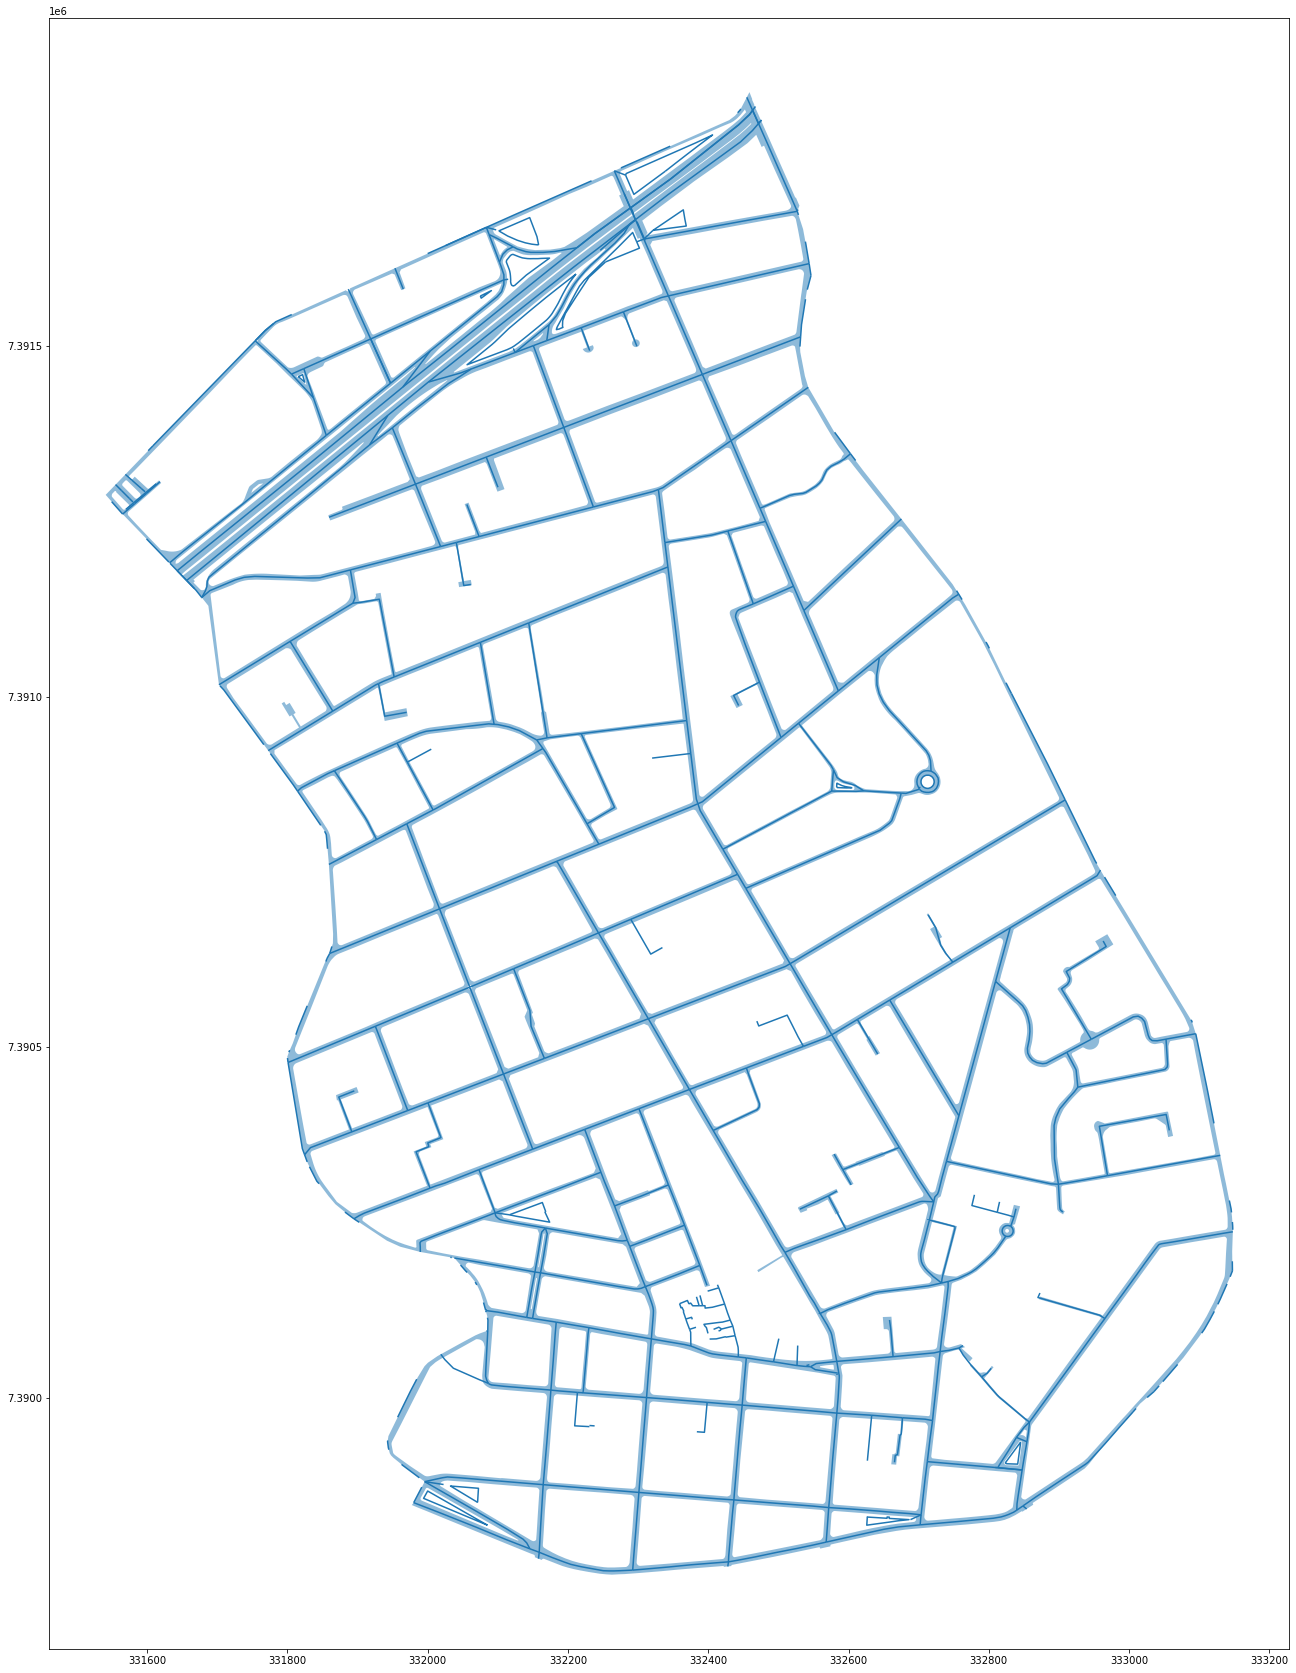

In [5]:
f, ax = plt.subplots(1)
df_vias.plot(ax=ax, alpha=0.5)
df_l.plot(ax=ax)
# df_logradouros.plot(ax=ax)

plt.show()

Obtendo os pontos finais e iniciais de cada logradouro podemos saber onde as ruas começam e terminam

In [6]:
gdf_cruzamentos_inicio = df_l['geometry'].map(lambda x: (x.interpolate(0, normalized=True)))
gdf_cruzamentos_final = df_l['geometry'].map(lambda x: (x.interpolate(1, normalized=True)))
gdf_cruzamentos =  pd.concat([gdf_cruzamentos_inicio, gdf_cruzamentos_final])
gdf_c = gdf_cruzamentos

Como alguns pontos acabam ficando muito próximos, seria interessante agregar todos os pontos do cruzamento.

In [8]:
cruzamentos = [p.centroid for p in gdf_c.buffer(5).unary_union]
df_cruzamentos = gpd.GeoDataFrame(geometry=cruzamentos)

In [9]:
df_pts = gpd.GeoDataFrame(geometry=df_cruzamentos.buffer(10).boundary.intersection(df_l.unary_union))

# filtrando somente os multipontos
df_cruzamentos = df_cruzamentos[df_pts.geometry.type == 'MultiPoint']
df_pts = df_pts[df_pts.geometry.type == 'MultiPoint']

In [10]:
# unir pontos e o ponto central do cruzamento
df_cruzamentos['id'] = df_cruzamentos.index.values
df_pts['id'] = df_pts.index.values

df_pt_pts = df_cruzamentos.merge(df_pts, on='id', suffixes=('_cruzamento', '_pt'))

In [11]:
# Calcular o angulo para cada ponto de intersecção
# e calcular a mediatriz desse pontos

import numpy as np

def calc_angulos(i):
    c_x, c_y = i.geometry_cruzamento.coords[0]
    coords = list(map(lambda x: x.coords[0], i.geometry_pt.geoms))
    p_x = np.array(list(map(lambda x: x[0], coords)))
    p_y = np.array(list(map(lambda x: x[1], coords)))
    delta_x, delta_y = [p_x - c_x, p_y - c_y]
    # Colocar os pontos em ordem de angulo
    angle = np.sort(np.arctan2(delta_x, delta_y) - 0.5 * np.pi)
    angle_normalized = angle / (np.pi * 2) + 0.75
    angle_plus = np.append(angle_normalized, 1 + angle_normalized[0:1])
    points = angle_normalized + (np.diff(angle_plus) / 2)
    points[-1] = points[-1] - 1
    return list(points)

angles = list(map(lambda x: calc_angulos(x), df_pt_pts.itertuples()))

In [12]:
df_bounds = gpd.GeoDataFrame(geometry=df_cruzamentos.buffer(10).boundary)
df_bounds['angles'] = angles
# angles

In [13]:
from shapely.geometry import MultiPoint

inter_points = list(map(
    lambda x: MultiPoint(list(map(
        lambda y: x.geometry.interpolate(y - 0.75, normalized=True), 
#         lambda y: x.geometry.interpolate(0.85, normalized=True),
        x.angles))), 
    df_bounds.itertuples()))

df_inter_points = gpd.GeoDataFrame(geometry=inter_points)

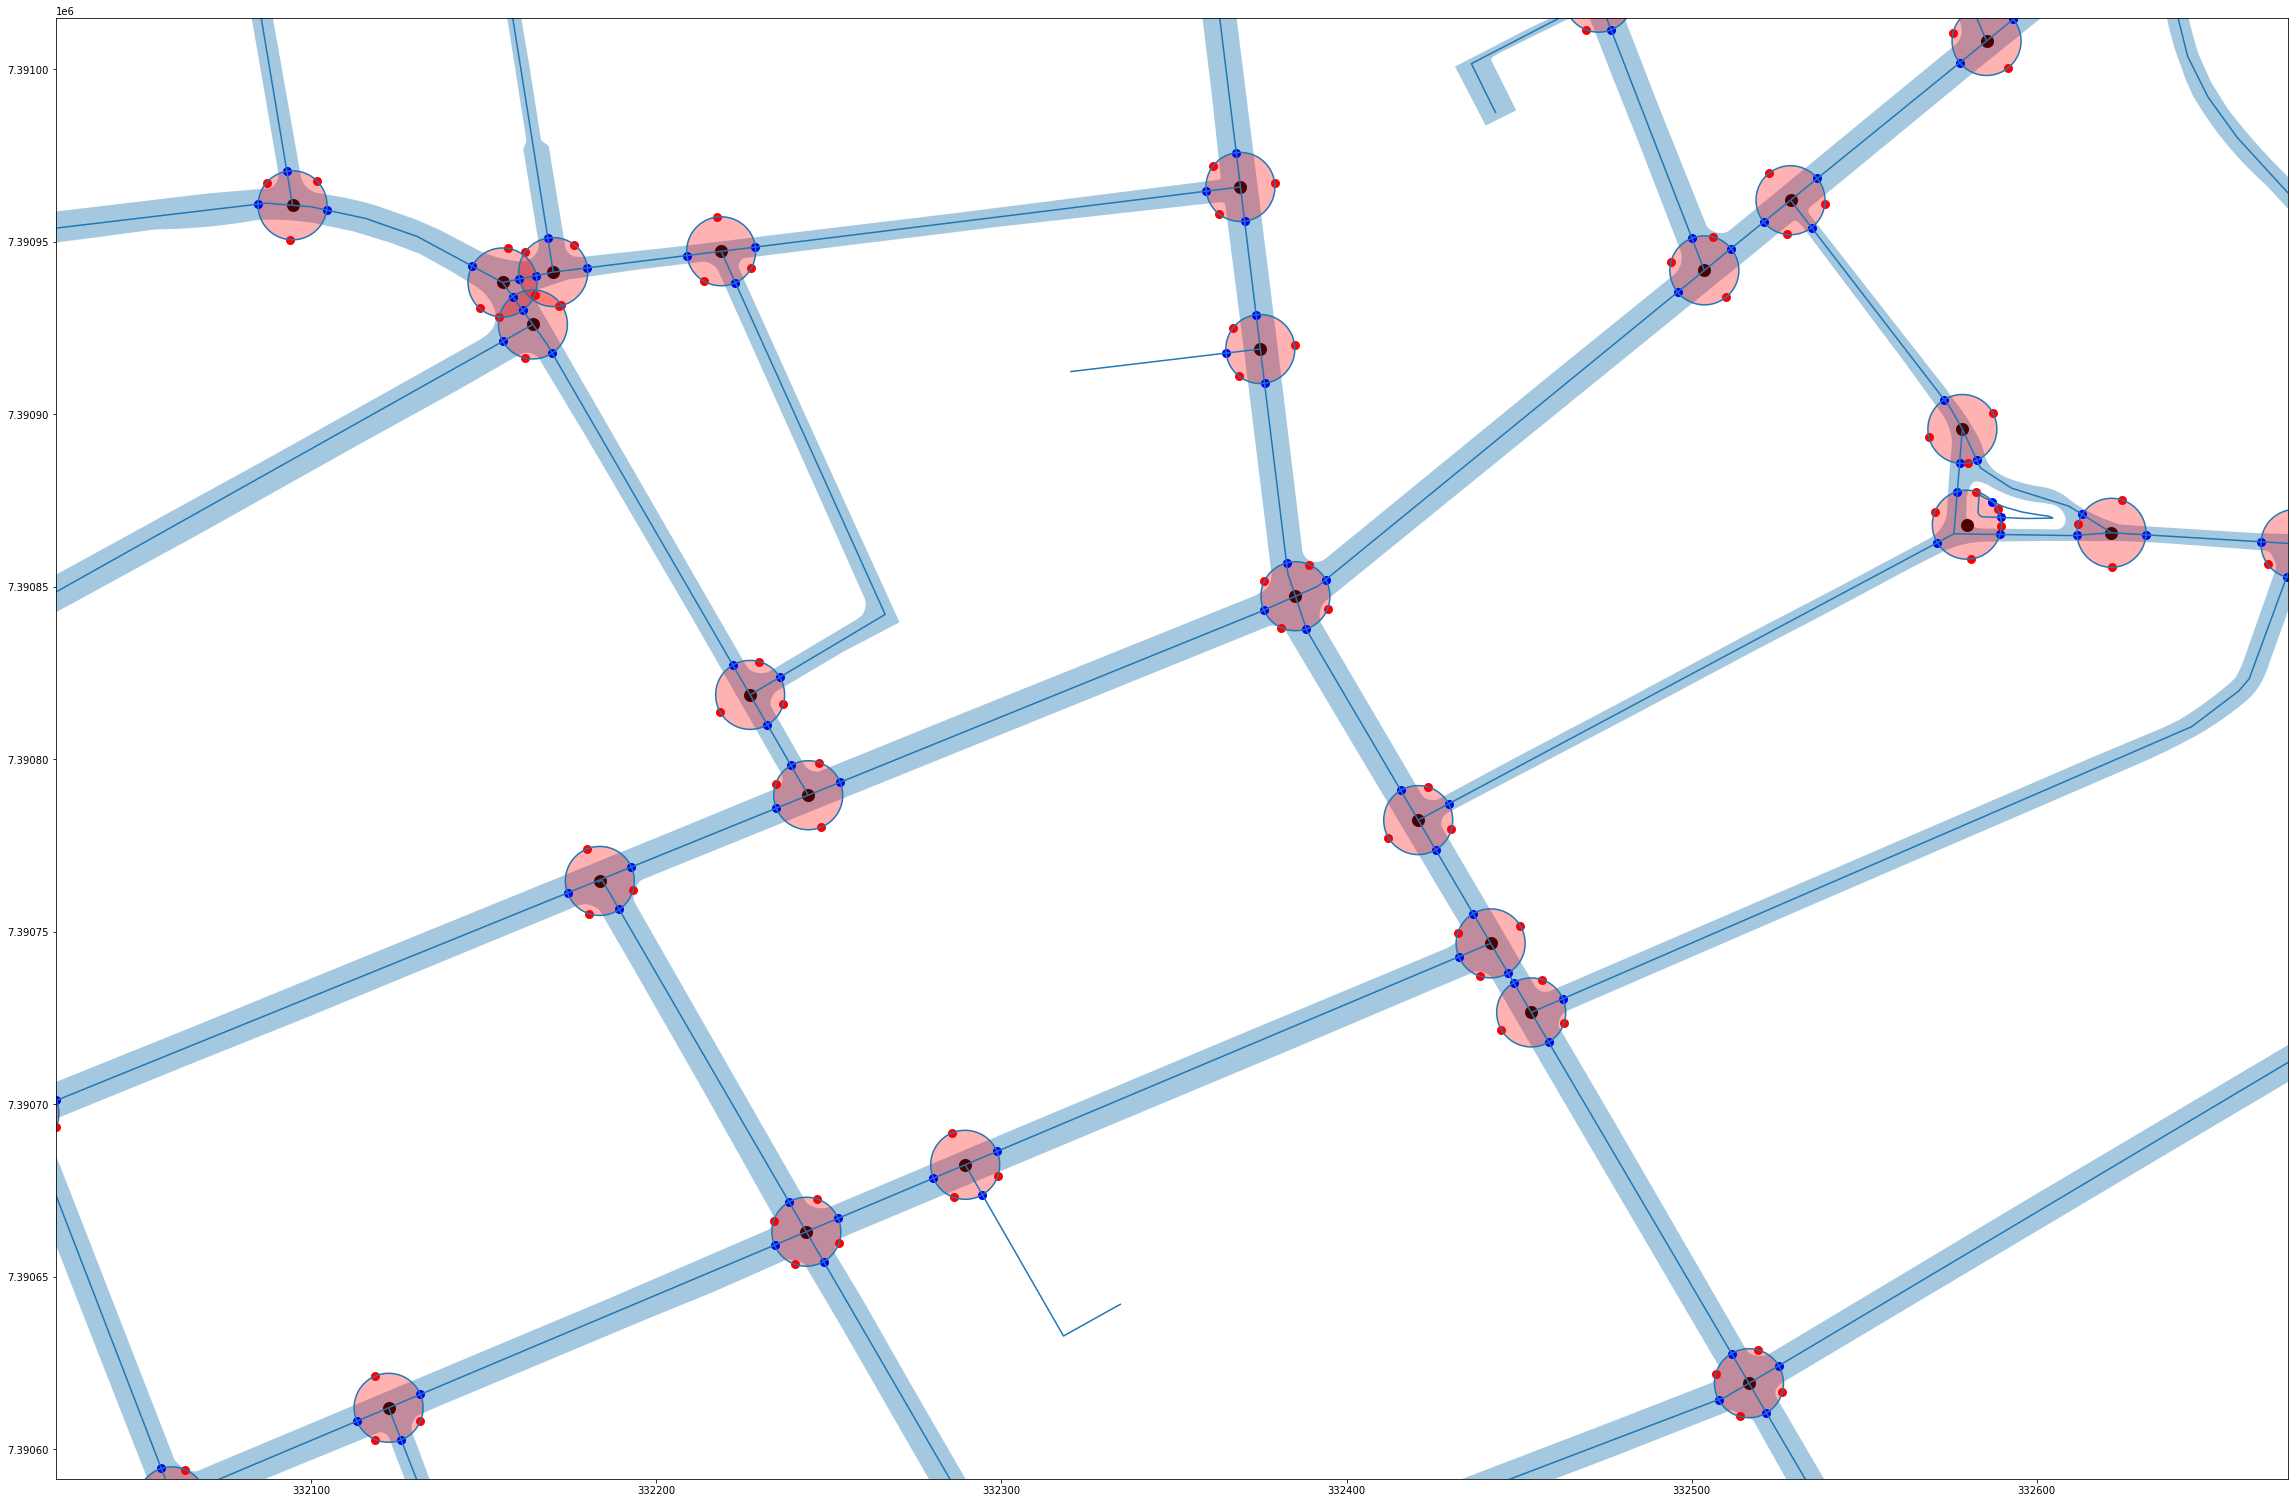

In [14]:
f, ax = plt.subplots(1)
df_vias.plot(ax=ax, alpha=0.4)
df_l.plot(ax=ax)
# df_cruz_buffer.plot(ax=ax, alpha=0.3, color='red')
df_cruzamentos.plot(ax=ax, lw=7, color='black')
df_cruzamentos.buffer(10).plot(ax=ax, alpha=0.3, color='red')
df_bounds.plot(ax=ax)
df_pts.plot(ax=ax, lw=3, color='blue')
df_inter_points.plot(ax=ax, lw=3, color='red')
# Aplicando o zoom
plt.margins(x=-0.30, y=-0.40)

plt.show()

## Criando linhas para 'cortar' os polígonos

Agora que temos que cortar o polígono precisamos de linhas para realizar esse fatiamento. 
Primeiramente vamos criar uma intersecção dos buffers dos nós com o traçado dos logradouros

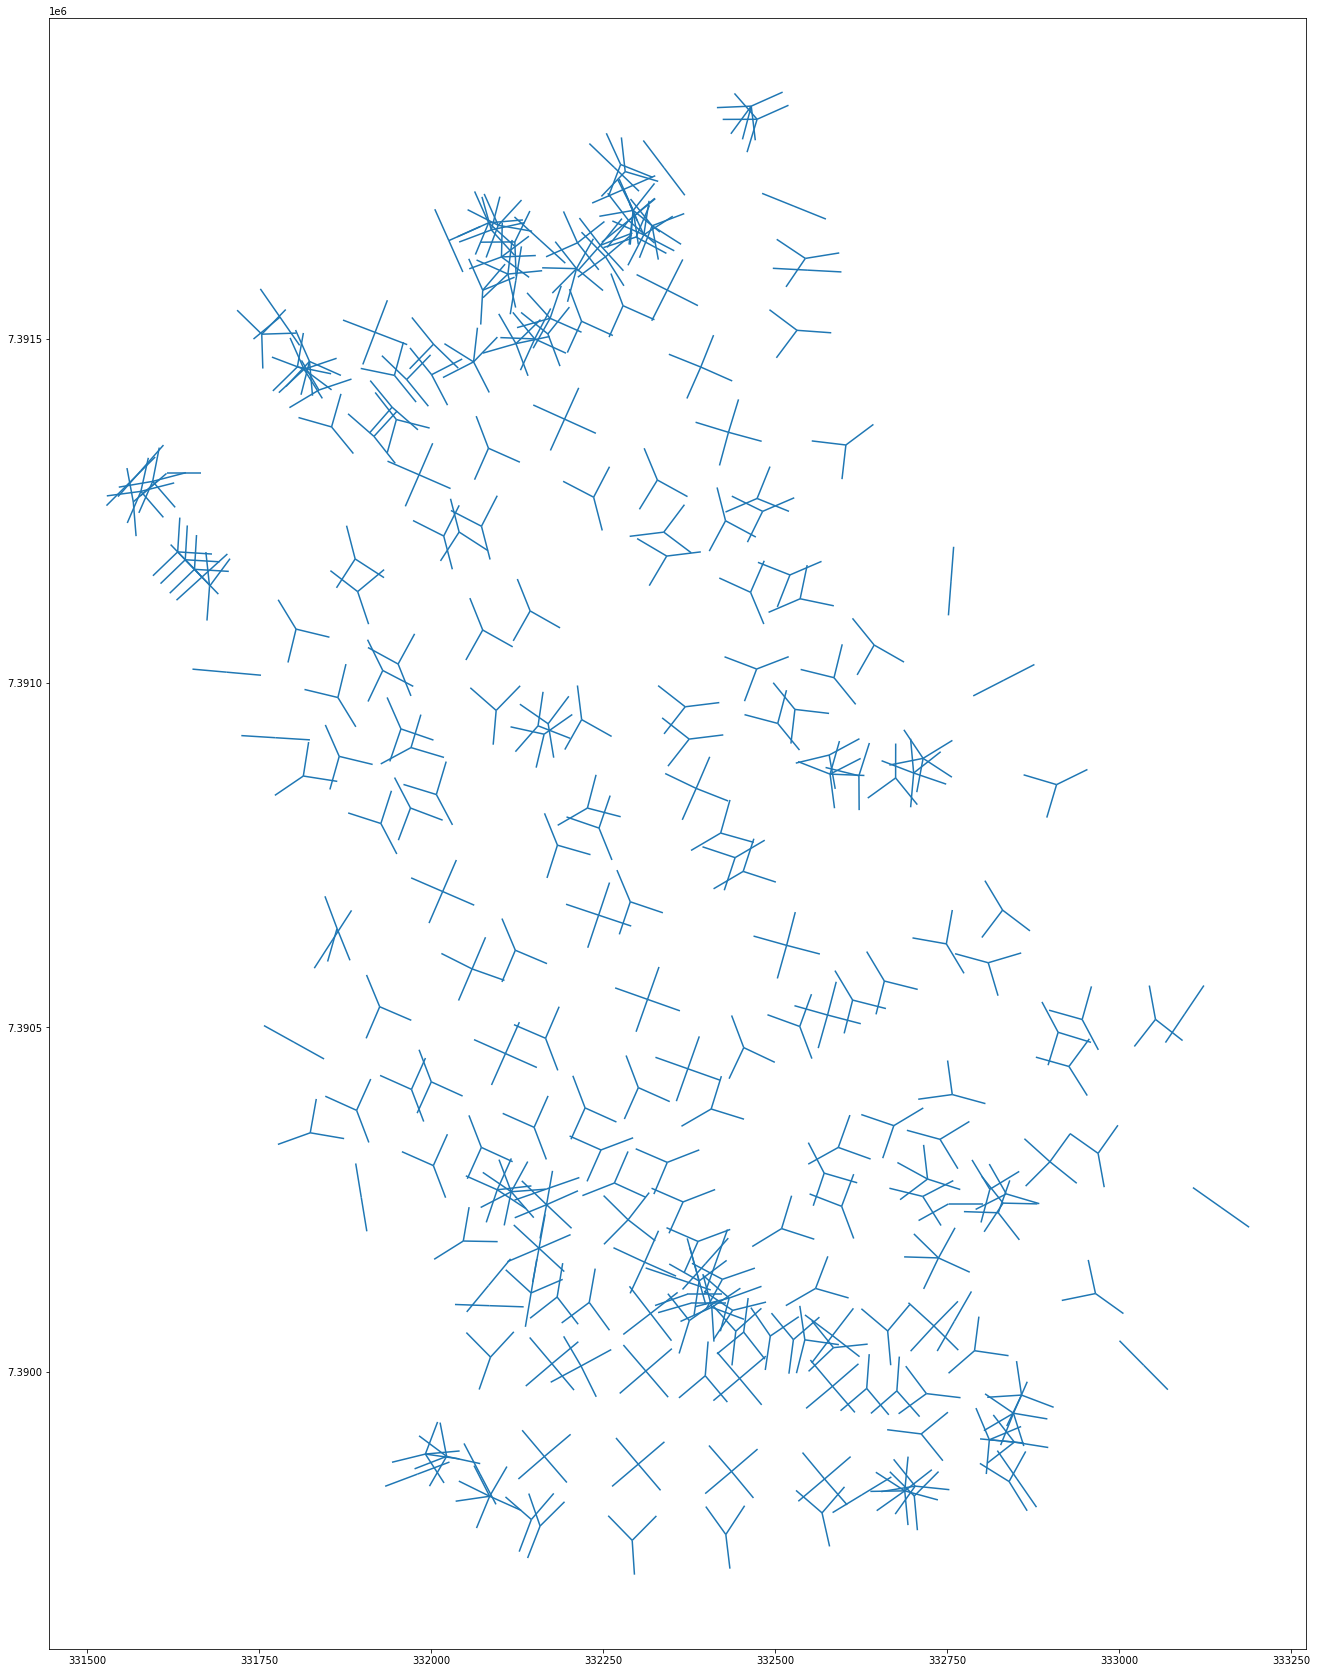

In [52]:
from shapely.geometry import MultiLineString, LineString
from shapely.affinity import scale

cut_lines = list(map(lambda x:
         scale(
             MultiLineString(list(map(lambda y: 
                  LineString([df_cruzamentos.geometry.iloc[x.Index], y]), 
                  x.geometry.geoms))),
             xfact = 5.0,
             yfact = 5.0,
             origin = df_cruzamentos.geometry.iloc[x.Index])
         , df_inter_points.itertuples()))

df_cut_lines = gpd.GeoDataFrame(geometry=cut_lines)
df_cut_lines.plot()

In [53]:
from libpysal.cg.voronoi  import voronoi, voronoi_frames

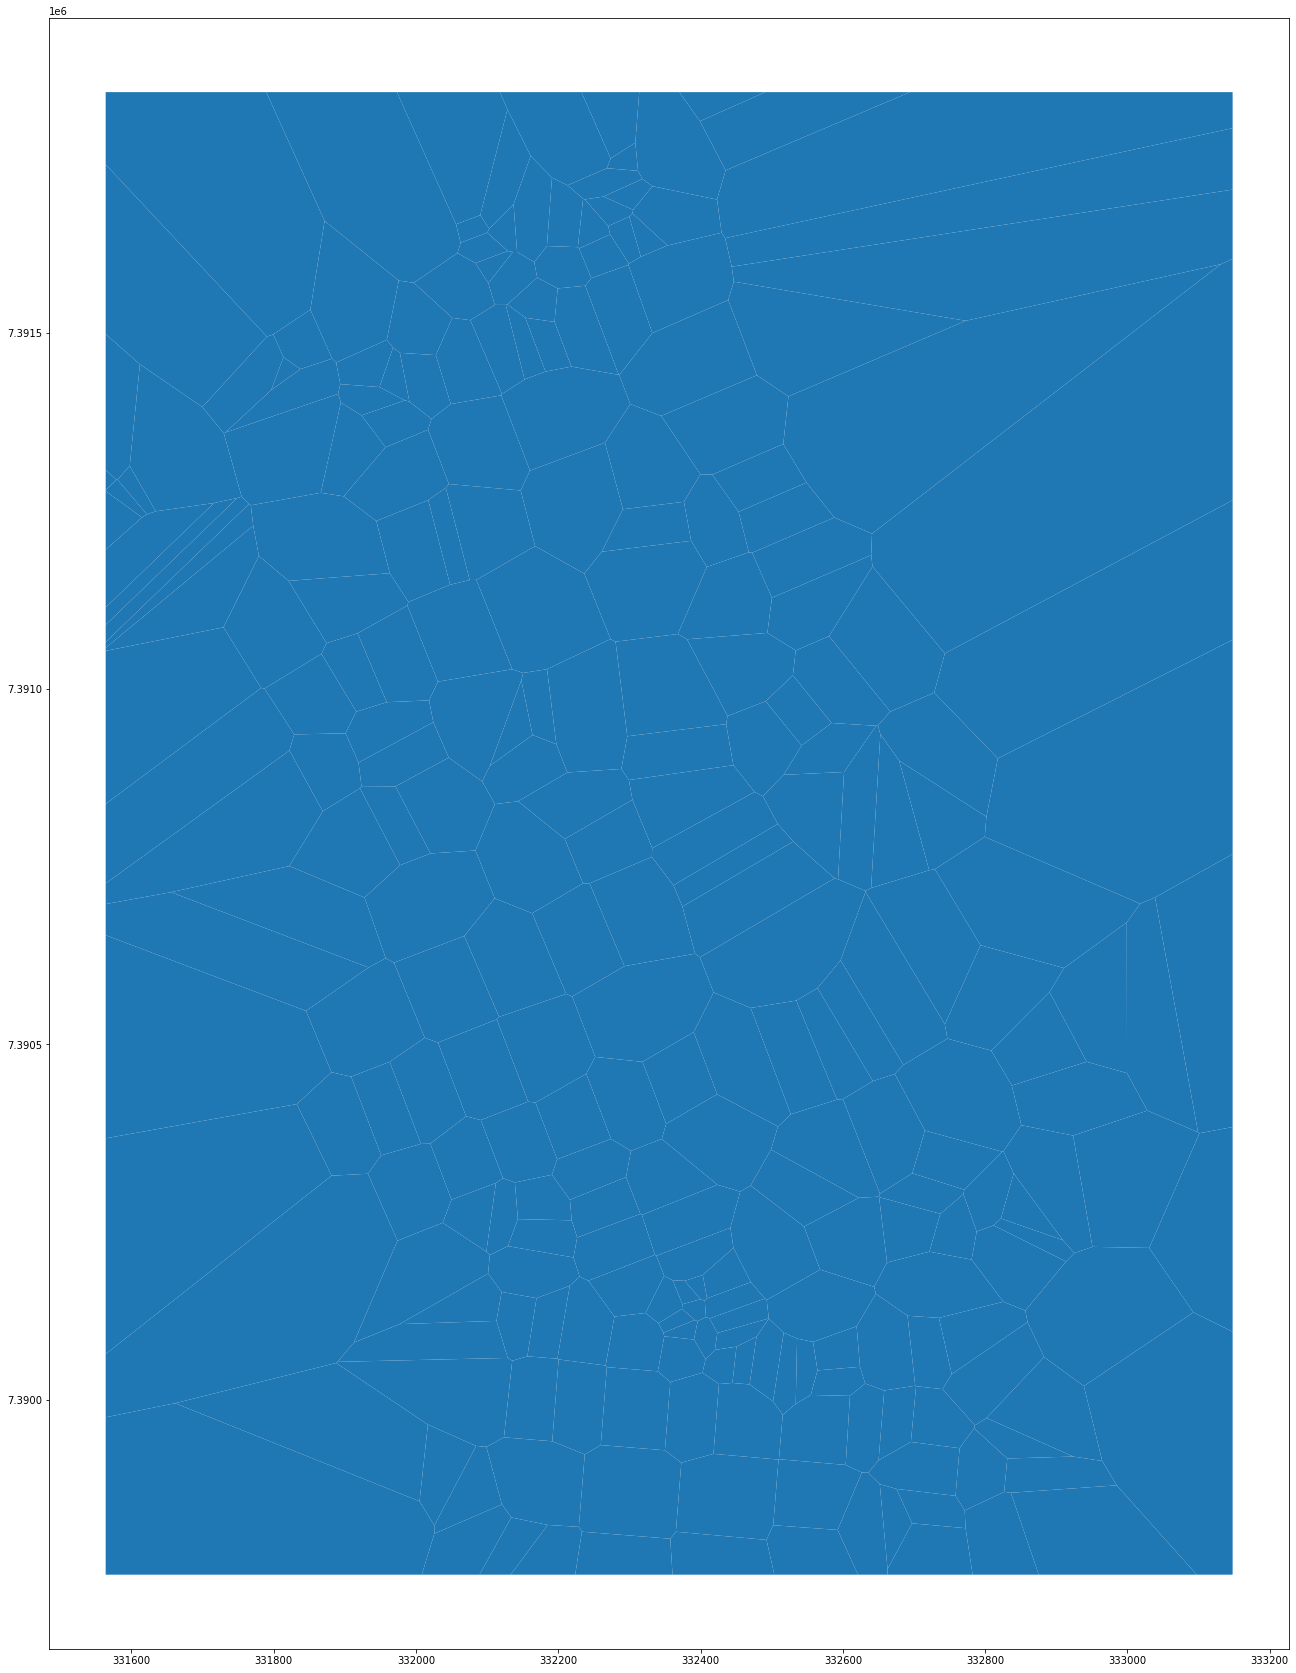

In [70]:
points = list(map(lambda x: [x.coords[0][0], x.coords[0][1]], df_cruzamentos.geometry))
df_voronoi_polygon, df_voronoi_point = voronoi_frames(points)
df_voronoi_polygon.plot()

## Agora voltando a trabalhar nas feições

Agora que conseguimos realizar a estratégia de traçar um buffer ao redor do cruzamento e então gerar linhas nas bissetrizes do traçado do viário podemos repetir o mesmo nas nossas feições.
Relembrando o que temos até aqui:

## Aparando as arestas

Como pudemos perceber o Poligonize acaba criando um polígono para qualquer área que tenha uma String circular. Uma boa etratégia seria:
- aparar as arestas das linhas 
- cortar o polígono de vias
- remover os polígonos das quadras
- plotar o resultado

## Salvando o resultado

Agora que temos o polígono de cada via, podemos salvar o resultado para seguir com alguma outra análise como:
- Calcular a largura mínima máxima e média de cada via